# Sudoku Solver with Linopy

The linopy package is good at tracking indices and writing optimization problems as vectorized functions (i.e., functions that operate on all rows of a column at once).  This notebook adapts the Medium article [Creating Sudoku Solver with Python and Pyomo in Easy Steps](https://medium.com/@dhanalakotamohan314/creating-sudoku-solver-with-python-and-pyomo-in-easy-steps-fe22ec916090) by Dhanalakota Mohan for linopy to demonstrate how indices (i.e., dimensions and coordinates) work.

In [1]:
import linopy
import xarray as xr
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.0f}'.format
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# The Puzzle

Sudoku is a 9x9 grid where each of digits 1 through 9 appears once and only once in each row, columns, and 3x3 grid.  The puzzle is initiated with a values in some of the rows and columns, which I'm calling hints.  Here is an example Sudoku puzzle with hints as a Pandas dataframe.  

In [2]:
# look at the hints for the puzzle  
puzzle_hints = [(1, 7, 2), (2, 2, 8), (2, 6, 7), (2, 8, 9),
                (3, 1, 6), (3, 3, 2), (3, 7, 5), (4, 2, 7),
                (4, 5, 6), (5, 4, 9), (5, 6, 1), (6, 5, 2), 
                (6, 8, 4), (7, 3, 5), (7, 7, 6), (7, 9, 3),
                (8, 2, 9), (8, 4, 4), (8, 8, 7), (9, 3, 6)]
puzzle_hints = pd.DataFrame(puzzle_hints, columns = ['row', 'column', 'digit'])
puzzle_hints_piv = puzzle_hints.pivot(index='row', columns='column', values='digit').replace(np.nan, '-')
puzzle_hints_piv


column,1,2,3,4,5,6,7,8,9
row,,,,,,,,,
1,-,-,-,-,-,-,2,-,-
2,-,8,-,-,-,7,-,9,-
3,6,-,2,-,-,-,5,-,-
4,-,7,-,-,6,-,-,-,-
5,-,-,-,9,-,1,-,-,-
6,-,-,-,-,2,-,-,4,-
7,-,-,5,-,-,-,6,-,3
8,-,9,-,4,-,-,-,7,-
9,-,-,6,-,-,-,-,-,-


# Defining Dimensions and Coordinates in Xarray
In Pandas parlance, the `index` are the row labels and `columns` are the column labels.  When converting to Xarray, it is handy to name the index and columns with `df.index.name = "row_name"` and `df.columns.name = "column_name"`.  

In Xarray parlance, the Pandas `df.index.name` and `df.columns.name` are both called `dimensions`.  Then the array of values of the index and columns are called `coordinates`.  Think of latitude and longitude as `dimensions` with `coordinate` values.  Xarray will infer the dimensions and coordinates from a Pandas DataFrame, provided columns and the index have names.  The following cell shows how this looks.     

In [3]:
xr.DataArray(puzzle_hints_piv)

<xarray.DataArray (row: 9, column: 9)> Size: 648B
array([['-', '-', '-', '-', '-', '-', 2.0, '-', '-'],
       ['-', 8.0, '-', '-', '-', 7.0, '-', 9.0, '-'],
       [6.0, '-', 2.0, '-', '-', '-', 5.0, '-', '-'],
       ['-', 7.0, '-', '-', 6.0, '-', '-', '-', '-'],
       ['-', '-', '-', 9.0, '-', 1.0, '-', '-', '-'],
       ['-', '-', '-', '-', 2.0, '-', '-', 4.0, '-'],
       ['-', '-', 5.0, '-', '-', '-', 6.0, '-', 3.0],
       ['-', 9.0, '-', 4.0, '-', '-', '-', 7.0, '-'],
       ['-', '-', 6.0, '-', '-', '-', '-', '-', '-']], dtype=object)
Coordinates:
  * row      (row) int64 72B 1 2 3 4 5 6 7 8 9
  * column   (column) int64 72B 1 2 3 4 5 6 7 8 9

In the Mohan article, the Sudoki puzzle is solved in a clever way.  Rather than select the digit for each (row, column) location in the grid, a third dimension is included which represents the digits 1, 2, 3, ... etc. that acts as an on-off switch for the value.  Here is what an empty (all zeros) Xarray DataArray will look like:    

In [4]:
range_coord = range(1, 10) 
xr.DataArray(np.zeros(shape=(9,9,9)), 
             dims=['row', 'column', 'digit'], 
             coords={'row': range_coord, 'column': range_coord, 'digit': range_coord})

<xarray.DataArray (row: 9, column: 9, digit: 9)> Size: 6kB
array([[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

...

       [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
Coordinates:
  * row      (row) int32 36B 1 2 3 4 5 6 7 8 9
  * column   (column) int32 36B 1 2 3 4 5 6 7 8 9
  * digit    (digit) int32 36B 1 2 3 4 5 6 7 8 9

And here is a graphical represenation:  

C:\Users\Gbrunkhorst\AppData\Local\Temp\ipykernel_8760\1405430973.py:72: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


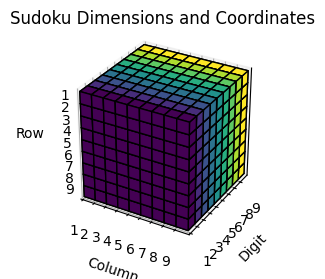

In [5]:
data = np.random.rand(9, 9, 9)
array = xr.DataArray(data, dims=['column', 'digit', 'row'])

# Function to create a single cube at a specific location
def create_cube(x, y, z, size=1):
    # Define the vertices of a cube
    vertices = [
        [x, y, z],
        [x + size, y, z],
        [x + size, y + size, z],
        [x, y + size, z],
        [x, y, z + size],
        [x + size, y, z + size],
        [x + size, y + size, z + size],
        [x, y + size, z + size]
    ]
    # Define the 6 faces of the cube
    faces = [
        [vertices[j] for j in [0, 1, 2, 3]],
        [vertices[j] for j in [4, 5, 6, 7]],
        [vertices[j] for j in [0, 3, 7, 4]],
        [vertices[j] for j in [1, 2, 6, 5]],
        [vertices[j] for j in [0, 1, 5, 4]],
        [vertices[j] for j in [2, 3, 7, 6]]
    ]
    return faces

# Create a 3D plot
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111, projection='3d')

# Colors for the slices
colors = plt.cm.viridis(np.linspace(0, 1, 9))

# Plot each cube
for i in range(9):
    for j in range(9):
        for k in range(9):
            faces = create_cube(i, j, k)
            poly3d = Poly3DCollection(faces, color=colors[j], edgecolor='k')  # Color by digit dimension
            ax.add_collection3d(poly3d)

# Set custom labels
ax.set_xlabel('Column')
ax.set_ylabel('Digit')
ax.set_zlabel('')
ax.set_title('Sudoku Dimensions and Coordinates')

# Customize ticks and labels
ticks = np.arange(9)
labels = np.arange(1, 10)  # Labels from 1 to 9
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_zticks([])  # Remove z-axis ticks
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Set the aspect ratio to be equal and adjust limits to fit the plot
ax.set_box_aspect([1, 1, 1])  # aspect ratio is 1:1:1
ax.set_xlim([0, 9])
ax.set_ylim([0, 9])
ax.set_zlim([0, 9])

# Adjust layout to ensure labels are visible
plt.subplots_adjust(left=0.5, right=0.8, top=0.9, bottom=0.0)

# Manually add z-axis labels
for z in range(9):
    ax.text(x=-1, y=-1, z=z + 0.5, s=9- z )
ax.text(x=-4, y=-1, z=4.5, s='Row', ha='center')

plt.tight_layout()

## Indices for the 3x3 Squares

If you play Sudoku, you know that there are 3x3 squares that get each digit once and only once.  There we need to get indices for the 3x3 squares.  We will label each of the square indices within the three dimensions and make an xarray.  Later, within the optimization model, we will use the square indices to mask out portions of the puzzle.  This is how we are indexing the squares:   

In [6]:
# Define the function to get the 3x3 square index
def get_square_index(row, col):
    return (row // 3) * 3 + (col // 3)

# Create the grid with row, column, and square indices
square_index = pd.DataFrame({
    'row': np.repeat(range_coord, 9),
    'column': list(range_coord) * 9,
    'square': [get_square_index(row-1, col-1)+1 for row in range_coord for col in range_coord]
})
square_index = square_index.pivot(index='row', columns='column', values='square')
square_index


column,1,2,3,4,5,6,7,8,9
row,,,,,,,,,
1,1,1,1,2,2,2,3,3,3
2,1,1,1,2,2,2,3,3,3
3,1,1,1,2,2,2,3,3,3
4,4,4,4,5,5,5,6,6,6
5,4,4,4,5,5,5,6,6,6
6,4,4,4,5,5,5,6,6,6
7,7,7,7,8,8,8,9,9,9
8,7,7,7,8,8,8,9,9,9
9,7,7,7,8,8,8,9,9,9


We put that in an xarray and then duplicate it across the third dimension "digit" for use in the model.  

In [7]:
square_index = xr.DataArray(square_index)
square_index_3d = xr.concat([square_index] * len(range_coord), dim='digit')
square_index_3d = square_index_3d.assign_coords(digit=range_coord)
square_index_3d

<xarray.DataArray (digit: 9, row: 9, column: 9)> Size: 6kB
array([[[1, 1, 1, 2, 2, 2, 3, 3, 3],
        [1, 1, 1, 2, 2, 2, 3, 3, 3],
        [1, 1, 1, 2, 2, 2, 3, 3, 3],
        [4, 4, 4, 5, 5, 5, 6, 6, 6],
        [4, 4, 4, 5, 5, 5, 6, 6, 6],
        [4, 4, 4, 5, 5, 5, 6, 6, 6],
        [7, 7, 7, 8, 8, 8, 9, 9, 9],
        [7, 7, 7, 8, 8, 8, 9, 9, 9],
        [7, 7, 7, 8, 8, 8, 9, 9, 9]],

       [[1, 1, 1, 2, 2, 2, 3, 3, 3],
        [1, 1, 1, 2, 2, 2, 3, 3, 3],
        [1, 1, 1, 2, 2, 2, 3, 3, 3],
        [4, 4, 4, 5, 5, 5, 6, 6, 6],
        [4, 4, 4, 5, 5, 5, 6, 6, 6],
        [4, 4, 4, 5, 5, 5, 6, 6, 6],
        [7, 7, 7, 8, 8, 8, 9, 9, 9],
        [7, 7, 7, 8, 8, 8, 9, 9, 9],
        [7, 7, 7, 8, 8, 8, 9, 9, 9]],

...

       [[1, 1, 1, 2, 2, 2, 3, 3, 3],
        [1, 1, 1, 2, 2, 2, 3, 3, 3],
        [1, 1, 1, 2, 2, 2, 3, 3, 3],
        [4, 4, 4, 5, 5, 5, 6, 6, 6],
        [4, 4, 4, 5, 5, 5, 6, 6, 6],
        [4, 4, 4, 5, 5, 5, 6, 6, 6],
        [7, 7, 7, 8, 8, 8, 9, 9, 9],
        [7, 7, 7, 8, 8, 8, 9, 9, 9],
        [7, 7, 7, 8, 8, 8, 9, 9, 9]],

       [[1, 1, 1, 2, 2, 2, 3, 3, 3],
        [1, 1, 1, 2, 2, 2, 3, 3, 3],
        [1, 1, 1, 2, 2, 2, 3, 3, 3],
        [4, 4, 4, 5, 5, 5, 6, 6, 6],
        [4, 4, 4, 5, 5, 5, 6, 6, 6],
        [4, 4, 4, 5, 5, 5, 6, 6, 6],
        [7, 7, 7, 8, 8, 8, 9, 9, 9],
        [7, 7, 7, 8, 8, 8, 9, 9, 9],
        [7, 7, 7, 8, 8, 8, 9, 9, 9]]], dtype=int64)
Coordinates:
  * row      (row) int32 36B 1 2 3 4 5 6 7 8 9
  * column   (column) int64 72B 1 2 3 4 5 6 7 8 9
  * digit    (digit) int32 36B 1 2 3 4 5 6 7 8 9

# Model

Now we get to the model.  Initalize a Linopy model.  

In [8]:
model = linopy.Model()

Make the binary `sudoku` variable for the model with the same dims and coords as above.

In [9]:
sudoku = model.add_variables(name='sudoku', 
                                 dims=square_index_3d.dims, 
                                 coords=square_index_3d.coords, 
                                 binary=True)

It is handy to look at what Linopy is doing.  The code defined as single variable, but it is indexed on a 9x9x9 cube, so it is really 729 variables.  

In [10]:
sudoku

Variable (row: 9, column: 9, digit: 9)
--------------------------------------
[1, 1, 1]: sudoku[1, 1, 1] ∈ {0, 1}
[1, 1, 2]: sudoku[1, 1, 2] ∈ {0, 1}
[1, 1, 3]: sudoku[1, 1, 3] ∈ {0, 1}
[1, 1, 4]: sudoku[1, 1, 4] ∈ {0, 1}
[1, 1, 5]: sudoku[1, 1, 5] ∈ {0, 1}
[1, 1, 6]: sudoku[1, 1, 6] ∈ {0, 1}
[1, 1, 7]: sudoku[1, 1, 7] ∈ {0, 1}
		...
[9, 9, 3]: sudoku[9, 9, 3] ∈ {0, 1}
[9, 9, 4]: sudoku[9, 9, 4] ∈ {0, 1}
[9, 9, 5]: sudoku[9, 9, 5] ∈ {0, 1}
[9, 9, 6]: sudoku[9, 9, 6] ∈ {0, 1}
[9, 9, 7]: sudoku[9, 9, 7] ∈ {0, 1}
[9, 9, 8]: sudoku[9, 9, 8] ∈ {0, 1}
[9, 9, 9]: sudoku[9, 9, 9] ∈ {0, 1}

Add the digit constraints to the model.  Each constraint sums across one of the dimensions, which holds the others constant for each summation.  By making the total == 1, the constrains ensure that the variable is turned on once and only once across that dimension.  In other words, we can't write a 1 and a 2 in the same square of the Sudoku puzzle.  The last constraint is displayed in Jupyter, which is helpful for seeing what is going on.  

In [11]:
model.add_constraints(sudoku.sum(dim=['column']) == 1, name='row_digit_constraint')
model.add_constraints(sudoku.sum(dim=['row']) == 1, name='column_digit_constraint')
model.add_constraints(sudoku.sum(dim=['digit']) == 1, name='row_column_constraint')

Constraint `row_column_constraint` (row: 9, column: 9):
-------------------------------------------------------
[1, 1]: +1 sudoku[1, 1, 1] + 1 sudoku[1, 1, 2] + 1 sudoku[1, 1, 3] ... +1 sudoku[1, 1, 7] + 1 sudoku[1, 1, 8] + 1 sudoku[1, 1, 9] = 1.0
[1, 2]: +1 sudoku[1, 2, 1] + 1 sudoku[1, 2, 2] + 1 sudoku[1, 2, 3] ... +1 sudoku[1, 2, 7] + 1 sudoku[1, 2, 8] + 1 sudoku[1, 2, 9] = 1.0
[1, 3]: +1 sudoku[1, 3, 1] + 1 sudoku[1, 3, 2] + 1 sudoku[1, 3, 3] ... +1 sudoku[1, 3, 7] + 1 sudoku[1, 3, 8] + 1 sudoku[1, 3, 9] = 1.0
[1, 4]: +1 sudoku[1, 4, 1] + 1 sudoku[1, 4, 2] + 1 sudoku[1, 4, 3] ... +1 sudoku[1, 4, 7] + 1 sudoku[1, 4, 8] + 1 sudoku[1, 4, 9] = 1.0
[1, 5]: +1 sudoku[1, 5, 1] + 1 sudoku[1, 5, 2] + 1 sudoku[1, 5, 3] ... +1 sudoku[1, 5, 7] + 1 sudoku[1, 5, 8] + 1 sudoku[1, 5, 9] = 1.0
[1, 6]: +1 sudoku[1, 6, 1] + 1 sudoku[1, 6, 2] + 1 sudoku[1, 6, 3] ... +1 sudoku[1, 6, 7] + 1 sudoku[1, 6, 8] + 1 sudoku[1, 6, 9] = 1.0
[1, 7]: +1 sudoku[1, 7, 1] + 1 sudoku[1, 7, 2] + 1 sudoku[1, 7, 3] ... +

If you play Sudoku, you know there is also the 3x3 square constraint.  The general concept is the same as above, where we are setting the sum == 1 such that each digit occurs once and only once.  This is not quite as elegant as the code above because it has some loops and we use `square_index_3d` to select the right coordinates in the puzzle.  We do this with the `.where` function in Linopy.  

In [12]:
for digit in range_coord:
    for square in range_coord:
        model.add_constraints(sudoku.where(square_index_3d==square).sel(digit=digit).sum() == 1,
                              name=f'digit{digit}_square{square}_constraint')

A Sudoku puzzle starts with some values already filled in.  These are also added to the model as constraints.  We add these by finding the right coordinates for each hint and making it == 1.  

In [13]:
for _, datum in puzzle_hints.iterrows():
    model.add_constraints(sudoku.loc[dict(row=datum.row, column=datum.column, digit=datum.digit)] == 1, 
                          name=f'hint_{datum.row}_{datum.column}_{datum.digit}_constraint')

I have been able to solve this without an objective, since the constraints lead to only one solution, but having an objective seems to help the solver.  

In [14]:
model.add_objective(sudoku.sum(), sense='max')

# Solve

Solve the model with the default solver (HiGHs)

In [15]:
model.solve()

Dual values of MILP couldn't be parsed


('ok', 'optimal')

The solution comes out as an xarray representing a cube of binary variables.  

In [16]:
solution = model.solution.sudoku
solution


<xarray.DataArray 'sudoku' (row: 9, column: 9, digit: 9)> Size: 6kB
array([[[0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.]],

...

       [[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.]]])
Coordinates:
  * row      (row) int32 36B 1 2 3 4 5 6 7 8 9
  * column   (column) int64 72B 1 2 3 4 5 6 7 8 9
  * digit    (digit) int32 36B 1 2 3 4 5 6 7 8 9

Squish the result down to two dimensions and put it in a DataFrame for display.  

In [17]:
final_sudoku_grid = xr.zeros_like(solution.sel(digit=1), dtype=int)
for digit in solution.digit.values:
    final_sudoku_grid += digit * solution.sel(digit=digit).astype(int)

result = pd.DataFrame(data=final_sudoku_grid.values, 
                                columns=puzzle_hints_piv.columns, 
                                index=puzzle_hints_piv.index)
result

column,1,2,3,4,5,6,7,8,9
row,,,,,,,,,
1,9,5,7,6,1,3,2,8,4
2,4,8,3,2,5,7,1,9,6
3,6,1,2,8,4,9,5,3,7
4,1,7,8,3,6,4,9,5,2
5,5,2,4,9,7,1,3,6,8
6,3,6,9,5,2,8,7,4,1
7,8,4,5,7,9,2,6,1,3
8,2,9,1,4,3,6,8,7,5
9,7,3,6,1,8,5,4,2,9


Looks like it was solved!  